In [2]:
import xarray as xr
from pathlib import Path
import holoviews as hv
import hvplot.pandas
import hvplot.xarray

<Axes: >

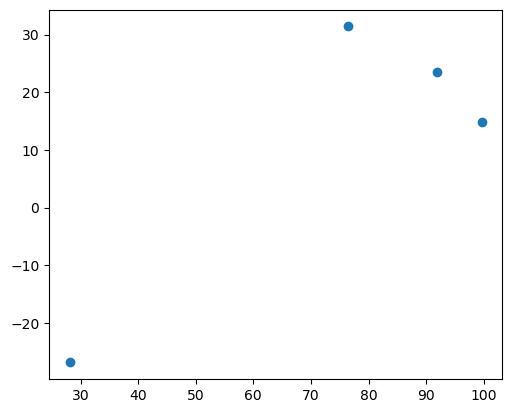

In [3]:
import geopandas as gpd
from pathlib import Path

# read the bounding box of the study area
val_pts = gpd.read_file(Path('../data/validation-locations/subset-validation-reservoirs-grand-pts.geojson'))
val_polys = gpd.read_file(Path('../data/validation-locations/subset-validation-reservoirs-grand.geojson'))

selected_reservoirs = [
    '0505', # dumboor. India
    # '0810', # sirindhorn, Thailand.
    '0830', # Krasoew, Thailand.
    '0502', # Bhakra dam, India.
    # '0518', # Bhadra, India.
    '0349', # vaaldam, South Africa.
    # '0464', # Sterkspruit, South Africa.
    # '0214', # Cijara, Spain
    # '1498', # Toledo bend, US
    # '0936', # Arrow, Canada
]

val_res_pt = val_pts.loc[val_pts['tmsos_id'].isin(selected_reservoirs)]
val_res_poly = val_polys.loc[val_polys['tmsos_id'].isin(selected_reservoirs)]

val_res_pt.plot()

In [4]:
# load
from pathlib import Path

hls_save_dir = Path('../data/hls')
hls_save_dir.mkdir(exist_ok=True)

dsses = []
reservoir_id = selected_reservoirs[0]
# for reservoir_id in selected_reservoirs:
print(reservoir_id)

savefp = hls_save_dir / f'{reservoir_id}.zarr'
ds = xr.open_zarr(savefp)

ds

0505


<xarray.Dataset> Size: 4GB
Dimensions:             (time: 277, y: 779, x: 650)
Coordinates:
    eo:cloud_cover_avg  (time) int64 2kB dask.array<chunksize=(30,), meta=np.ndarray>
    platform            (time) <U11 12kB dask.array<chunksize=(30,), meta=np.ndarray>
    reservoir           <U4 16B ...
    spatial_ref         int32 4B ...
  * time                (time) datetime64[ns] 2kB 2019-01-02T04:41:48.360000 ...
  * x                   (x) float64 5kB 3.732e+05 3.732e+05 ... 3.926e+05
  * y                   (y) float64 6kB 2.61e+06 2.61e+06 ... 2.587e+06
Data variables:
    Fmask               (time, y, x) float32 561MB dask.array<chunksize=(30, 779, 650), meta=np.ndarray>
    blue                (time, y, x) float32 561MB dask.array<chunksize=(30, 779, 650), meta=np.ndarray>
    green               (time, y, x) float32 561MB dask.array<chunksize=(30, 779, 650), meta=np.ndarray>
    ndwi                (time, y, x) float32 561MB dask.array<chunksize=(30, 779, 650), meta=np.ndarray>
    nir narrow          (time, y, x) float32 561MB dask.array<chunksize=(30, 779, 650), meta=np.ndarray>
    red                 (time, y, x) float32 561MB dask.array<chunksize=(30, 779, 650), meta=np.ndarray>
    swir 1              (time, y, x) float32 561MB dask.array<chunksize=(30, 779, 650), meta=np.ndarray>
    swir 2              (time, y, x) float32 561MB dask.array<chunksize=(30, 779, 650), meta=np.ndarray>

In [4]:
from shapely.geometry import mapping
from holoviews.streams import Selection1D


def get_hls_area(ds, reservoir_id, val_res_poly, save_dir=None):
    res_id = reservoir_id

    res_poly = val_res_poly[val_res_poly['tmsos_id']==ds.reservoir.values]

    val_buffered_polys = res_poly.copy()
    area = val_buffered_polys['AREA_SKM_right'].loc[val_buffered_polys['tmsos_id'] == reservoir_id]
    buffer_area = area.values[0] * 0.00075
    val_buffered_polys['geometry'] = val_buffered_polys['geometry'].buffer(buffer_area)

    # water_map = ds['ndwi'] > -0.3

    # water_map = water_map.dropna(dim='time')

    # water_map.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
    # water_map.rio.write_crs(f"epsg:{water_map.spatial_ref.values}", inplace=True)

    # water_map_area = water_map.sum(dim=['x', 'y']) * 1e2 * 1e-6
    
    # # clipped = water_map.rio.clip(res_poly.geometry.apply(mapping), res_poly.crs, drop=True)

    return val_buffered_polys

get_hls_area(ds, '0505', val_res_poly)

/tmp/ipykernel_239336/3488060218.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  val_buffered_polys['geometry'] = val_buffered_polys['geometry'].buffer(buffer_area)


,GRAND_ID_left,RES_NAME_left,DAM_NAME_left,ALT_NAME_left,RIVER_left,ALT_RIVER_left,MAIN_BASIN_left,SUB_BASIN_left,NEAR_CITY_left,ALT_CITY_left,...,db,name,rid_id,grand_id,rid_filepath,resops_id,rid_filename,tmsos_id,distance,geometry
82,5121,None,Gumti,None,Gumti,None,Brahmaputra-Meghna,None,Amarpur,None,...,deltares,None,NaN,NaN,None,NaN,None,0505,NaN,"POLYGON ((91.86790 23.41564, 91.86638 23.41573..."


In [5]:
val_buffered_polys = val_res_poly.copy()
print(val_buffered_polys['AREA_SKM_right'])

water_map = (ds['ndwi'] > 0).rename('water')

ds['ndwi'].hvplot(
    x='x', y='y', groupby='time', geo=True, clim=(-1, 0.3), cmap='RdYlBu'
) * water_map.hvplot(
    x='x', y='y', groupby='time', geo=True, alpha=0.3, color='blue'
).opts(
    xlabel='Longitude', ylabel='Latitude', title=f'Dumboor - Harmonized Landsat Sentinel-2 NDWI'
) * val_buffered_polys.loc[val_buffered_polys['tmsos_id'] == reservoir_id].hvplot(geo=True, color='black', alpha=0.2)

47    287.81
60     91.94
82     34.41
92     38.42
Name: AREA_SKM_right, dtype: float64


BokehModel(combine_events=True, render_bundle={'docs_json': {'ee19ff5a-af01-43bb-8231-0783dae5a2f0': {'version…